# UNet++ for Flood Area Segmentation
This notebook implements UNet++ on the flood area segmentation dataset. It leverages the `segmentation_models_pytorch` library for model implementation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import segmentation_models_pytorch as smp
print(smp.__version__)

np.random.seed(42)
torch.manual_seed(42)

%matplotlib inline

/home/procoder/Documents/Deep Learning/dlProject/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.3.5dev0


# Load Data


In [2]:
# Define paths to images and masks
IMAGES_DIR = 'data/Image/'
LABELS_DIR = 'data/Mask/'

# Read metadata
metadata = pd.read_csv('data/metadata.csv')
metadata.head()

,Image,Mask
0,0.jpg,0.png
1,1.jpg,1.png
2,2.jpg,2.png
3,3.jpg,3.png
4,4.jpg,4.png


In [3]:
def get_all_images_labels(IMAGES_DIR, LABELS_DIR, metadata):
    """
    Return the list of all valid images and labels
    """
    images = []
    labels = []
    min_h = 1e6; max_h = 0
    min_w = 1e6; max_w = 0
    for _, row in metadata.iterrows():
        image_path = os.path.join(IMAGES_DIR, row['Image'])
        label_path = os.path.join(LABELS_DIR, row['Mask'])
        img_arr = np.array(Image.open(image_path))
        label_arr = np.array(Image.open(label_path))
        if (img_arr.ndim == 3) and (img_arr.shape[2] == 3) and (img_arr.shape[:-1] == label_arr.shape):
            min_h = min(min_h, img_arr.shape[0]); max_h = max(max_h, img_arr.shape[0])
            min_w = min(min_w, img_arr.shape[1]); max_w = max(max_w, img_arr.shape[1])
            images.append(image_path)
            labels.append(label_path)
        else:
            print(f"Skipping image {row['Image']} and mask {row['Mask']}")
    print(f"Min height: {min_h}, Max height: {max_h}")
    print(f"Min width: {min_w}, Max width: {max_w}")
    return images, labels

all_images, all_labels = get_all_images_labels(IMAGES_DIR, LABELS_DIR, metadata)
print(f"Total images: {len(all_images)}")

Skipping image 0.jpg and mask 0.png
Skipping image 2.jpg and mask 2.png
Skipping image 14.jpg and mask 14.png
Skipping image 15.jpg and mask 15.png
Skipping image 2052.jpg and mask 2052.png
Skipping image 2053.jpg and mask 2053.png
Skipping image 3048.jpg and mask 3048.png
Skipping image 3059.jpg and mask 3059.png
Skipping image 1061.jpg and mask 1061.png
Skipping image 1079.jpg and mask 1079.png
Min height: 219, Max height: 3648
Min width: 330, Max width: 5472
Total images: 280


In [4]:
# Split the data into training, validation, and test sets

TRAIN_SIZE = 200
VAL_SIZE = 20
TEST_SIZE = 60

image_paths_train = all_images[:TRAIN_SIZE]
label_paths_train = all_labels[:TRAIN_SIZE]

image_paths_val = all_images[TRAIN_SIZE:TRAIN_SIZE+VAL_SIZE]
label_paths_val = all_labels[TRAIN_SIZE:TRAIN_SIZE+VAL_SIZE]

image_paths_test = all_images[-TEST_SIZE:]
label_paths_test = all_labels[-TEST_SIZE:]

print(f"Training images: {len(image_paths_train)}")
print(f"Validation images: {len(image_paths_val)}")
print(f"Test images: {len(image_paths_test)}")

Training images: 200
Validation images: 20
Test images: 60


# Dataset and Dataloader

In [5]:
class FloodDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_paths[idx]).convert("L"))
        
        # Convert mask to binary
        mask = (mask >= 128).astype('float32')
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Move channels first
        image = np.transpose(image, (2, 0, 1)).astype('float32')
        return torch.tensor(image), torch.tensor(mask).unsqueeze(0)

In [6]:
# Compute dataset mean and std for normalization
def compute_mean_std(image_paths):
    """
    Compute the mean and standard deviation of the dataset.
    """
    means = []
    stds = []
    for path in tqdm(image_paths, desc="Computing mean and std"):
        image = np.array(Image.open(path).convert("RGB")).astype('float32') / 255.0
        means.append(np.mean(image, axis=(0,1)))
        stds.append(np.std(image, axis=(0,1)))
    mean = np.mean(means, axis=0)
    std = np.mean(stds, axis=0)
    return mean, std

mean, std = compute_mean_std(image_paths_train)
print(f"Mean: {mean}, Std: {std}")

Computing mean and std: 100%|██████████| 200/200 [00:18<00:00, 10.79it/s]

Mean: [0.50019354 0.4970171  0.44732517], Std: [0.21560247 0.19379494 0.20825012]


In [7]:
# Define transformations
H = 512
W = 512

# Convert mean and std to lists
mean = mean.tolist()
std = std.tolist()

train_transform = A.Compose([
    A.Resize(height=H, width=W),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=mean, std=std),
])

val_transform = A.Compose([
    A.Resize(height=H, width=W),
    A.Normalize(mean=mean, std=std),
])

In [8]:
# Create datasets
train_dataset = FloodDataset(image_paths_train, label_paths_train, transform=train_transform)
val_dataset = FloodDataset(image_paths_val, label_paths_val, transform=val_transform)
test_dataset = FloodDataset(image_paths_test, label_paths_test, transform=val_transform)

In [9]:
# Create data loaders
BATCH_SIZE = 4

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model Setup

In [10]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.5.1+cu124
CUDA available: True


In [11]:
import torch

# Check if CUDA is available
print(f"CUDA available: {torch.cuda.is_available()}")

# Print CUDA device
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")

CUDA available: True
CUDA Device: NVIDIA GeForce RTX 3060 Laptop GPU


In [12]:
# Initialize the UNet++ model
model = smp.UnetPlusPlus(
    encoder_name='resnet34',        # Choose encoder, e.g. resnet34 or efficientnet-b0
    encoder_weights='imagenet',     # Use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # Model input channels (1 for grayscale images, 3 for RGB)
    classes=1,                      # Model output channels (number of classes)
    activation=None,                # No activation, we'll apply Sigmoid during training
)

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f'Model loaded on {device}')

Model loaded on cuda


In [13]:
import torch
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, outputs, targets):
        # Apply sigmoid to get probabilities
        outputs = torch.sigmoid(outputs)
        # Flatten tensors
        outputs = outputs.view(-1)
        targets = targets.view(-1)
        # Compute Dice Loss
        intersection = (outputs * targets).sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (outputs.sum() + targets.sum() + self.smooth)
        return dice_loss

In [14]:
def iou_metric(outputs, targets, threshold=0.5, smooth=1e-6):
    outputs = torch.sigmoid(outputs)
    outputs = (outputs > threshold).float()
    targets = targets.float()
    # Flatten tensors
    outputs = outputs.view(-1)
    targets = targets.view(-1)
    # Compute IoU
    intersection = (outputs * targets).sum()
    total = (outputs + targets).sum()
    union = total - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

In [15]:
# # Define loss function and metrics for SMP v0.3.4
# loss_fn = smp.utils.losses.DiceLoss()
# metrics = [smp.utils.metrics.IoU(threshold=0.5)]

# # Define the optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training Loop

In [16]:
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    for images, masks in tqdm(loader, desc="Training", leave=False):
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate IoU
        iou = iou_metric(outputs, masks)
        total_iou += iou.item()
    
    avg_loss = total_loss / len(loader)
    avg_iou = total_iou / len(loader)
    return avg_loss, avg_iou

In [17]:
def validate(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation", leave=False):
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            
            total_loss += loss.item()
            
            # Calculate IoU
            iou = iou_metric(outputs, masks)
            total_iou += iou.item()
    
    avg_loss = total_loss / len(loader)
    avg_iou = total_iou / len(loader)
    return avg_loss, avg_iou

In [18]:
# Define loss function
loss_fn = DiceLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [19]:
# Number of epochs
num_epochs = 10
best_iou = 0.0

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    
    # Train
    train_loss, train_iou = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    print(f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}")
    
    # Validate
    val_loss, val_iou = validate(model, val_loader, loss_fn, device)
    print(f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")
    
    # Save the best model
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), 'best_unetplusplus_model.pth')
        print("Model saved!")


Epoch 1/10


Train Loss: 0.3657, Train IoU: 0.6261


Val Loss: 0.2296, Val IoU: 0.7978
Model saved!

Epoch 2/10


Train Loss: 0.2356, Train IoU: 0.7828


Val Loss: 0.1867, Val IoU: 0.7964

Epoch 3/10


Train Loss: 0.1884, Train IoU: 0.8092


Val Loss: 0.1539, Val IoU: 0.8093
Model saved!

Epoch 4/10


Train Loss: 0.1589, Train IoU: 0.8275


Val Loss: 0.1450, Val IoU: 0.8192
Model saved!

Epoch 5/10


Train Loss: 0.1417, Train IoU: 0.8382


Val Loss: 0.1369, Val IoU: 0.8162

Epoch 6/10


Train Loss: 0.1287, Train IoU: 0.8447


Val Loss: 0.1256, Val IoU: 0.8291
Model saved!

Epoch 7/10


Train Loss: 0.1185, Train IoU: 0.8512


Val Loss: 0.1259, Val IoU: 0.8175

Epoch 8/10


Train Loss: 0.1045, Train IoU: 0.8657


Val Loss: 0.1260, Val IoU: 0.8221

Epoch 9/10


Train Loss: 0.0936, Train IoU: 0.8764


Val Loss: 0.1162, Val IoU: 0.8201

Epoch 10/10


Train Loss: 0.0928, Train IoU: 0.8710


Val Loss: 0.1135, Val IoU: 0.8225


# Evaluation on Test Set

In [20]:
# Load the best saved model
model.load_state_dict(torch.load('best_unetplusplus_model.pth'))
model.eval()

# Evaluation function
def evaluate_model(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            total_loss += loss.item()
            
            iou = iou_metric(outputs, masks)
            total_iou += iou.item()
    
    avg_loss = total_loss / len(loader)
    avg_iou = total_iou / len(loader)
    print(f"Test Loss: {avg_loss:.4f}, Test IoU: {avg_iou:.4f}")
    return avg_loss, avg_iou

# Evaluate on test set
test_loss, test_iou = evaluate_model(model, test_loader, loss_fn, device)

/tmp/ipykernel_29272/3537722893.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_unetplusplus_model.pth'))
Evaluating: 100%|███████

Test Loss: 0.1475, Test IoU: 0.8032


# Visualization

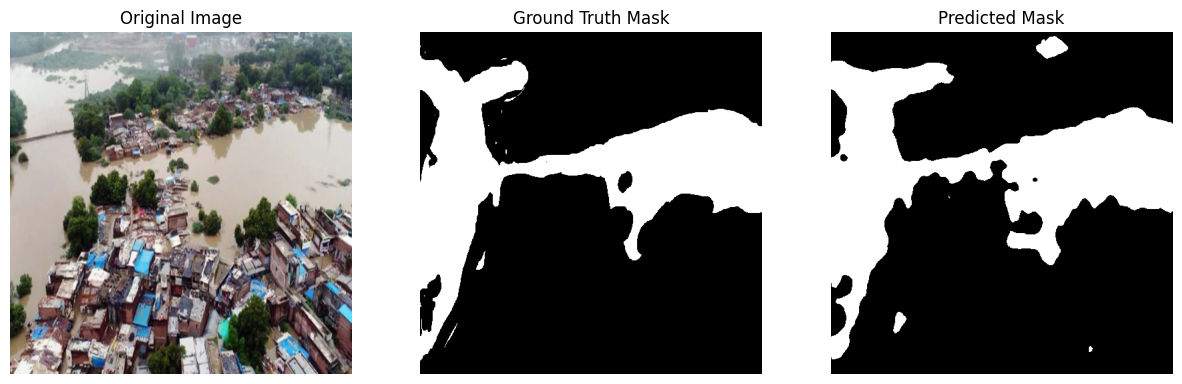

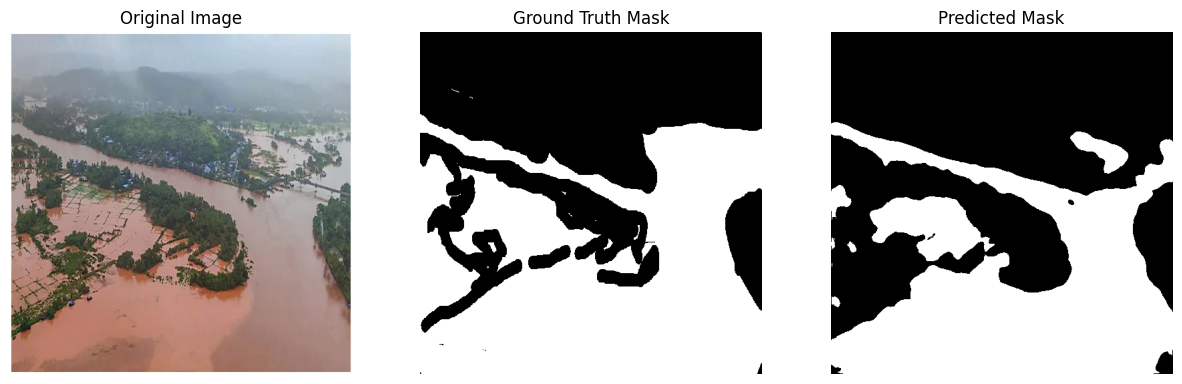

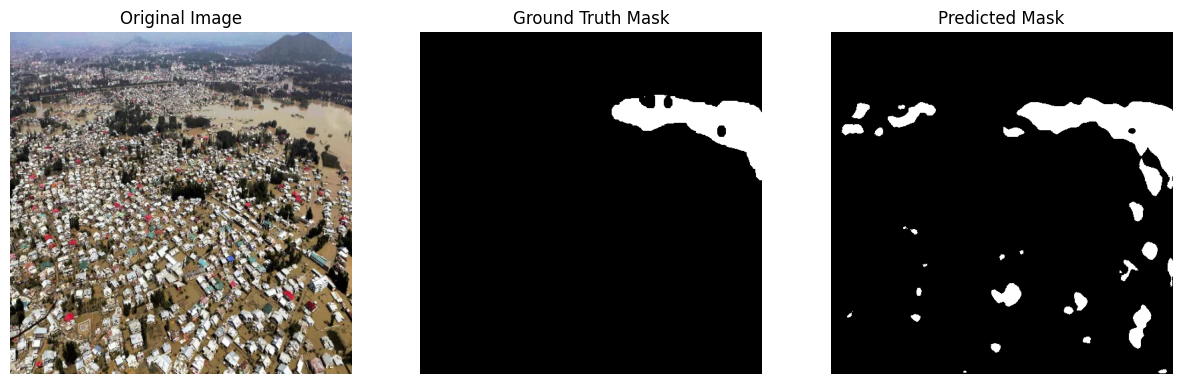

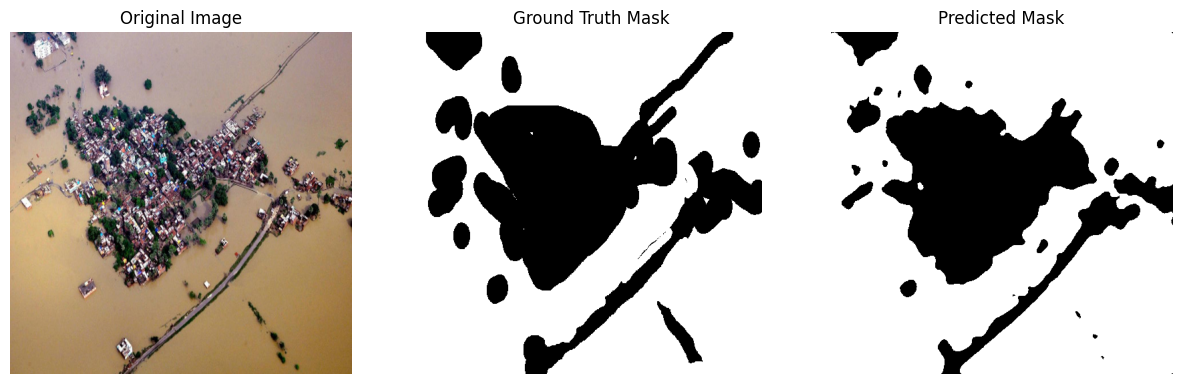

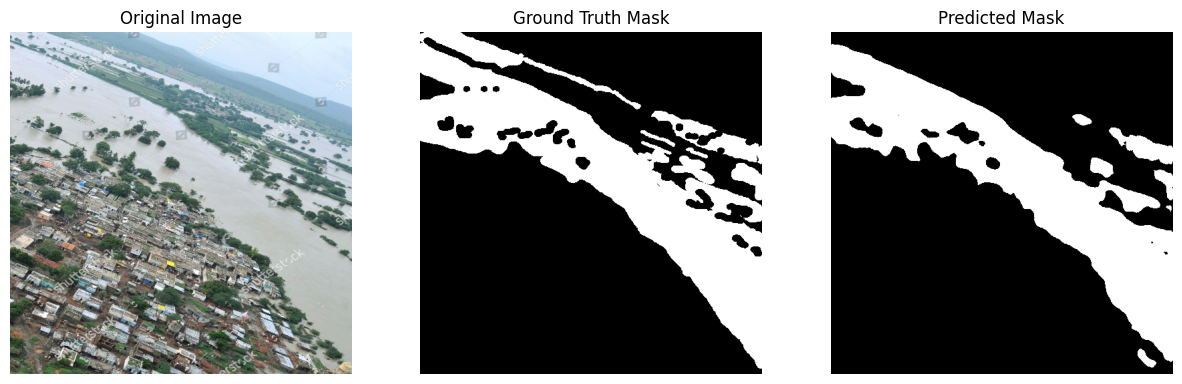

In [21]:
def visualize_predictions(model, dataset, num_samples=5):
    model.eval()
    for i in range(num_samples):
        image, mask = dataset[i]
        image_input = image.to(device).unsqueeze(0)
        mask = mask.squeeze().cpu().numpy()
        
        with torch.no_grad():
            output = model(image_input)
            output = torch.sigmoid(output)
            pred_mask = (output.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
        
        # Denormalize the image for visualization
        image_np = image.cpu().numpy()
        image_np = np.transpose(image_np, (1, 2, 0))
        image_np = (image_np * std + mean) * 255.0
        image_np = np.clip(image_np, 0, 255).astype(np.uint8)
        
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image_np)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
        
        plt.show()

# Visualize predictions on test set
visualize_predictions(model, test_dataset, num_samples=5)